In [3]:
import os
from os.path import join, exists
import itertools
from functools import partial

import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import hilbert
from scipy.stats import pearsonr

from mne.connectivity import spectral_connectivity, phase_slope_index

In [32]:
path_file = '../own_data/190526_portnova_deti_path_file.csv'
data_path = '../own_data/autists_proc_a1'

In [5]:
path_df = pd.read_csv(path_file)

In [6]:
path_df = path_df[path_df['seconds'] >= 30]

In [5]:
foo = pd.read_csv(join(data_path, path_df.iloc[5]['fn'] + '.csv'))

In [65]:
electrodes = [
    'fp1',
    'fp2',
    'f7',
    'f3',
    'fz',
    'f4',
    'f8',
    't3',
    'c3',
#     'c4',
    't4',
#     't5',
#     'p3',
    'pz',
    'p4',
    't6',
    'o1',
    'o2',
#     'a1',
    'a2',
    'cz'
]

idx_electrodes_dict = {i: e for i, e in enumerate(electrodes)}

In [78]:
foo = pd.read_csv('../own_data/autists_proc_a1/AKSUK_NIKITA_11_EO_long.csv', index_col='time')

In [79]:
bar = pd.read_csv('../own_data/autists_proc/AKSUK_NIKITA_11_EO_long.csv', index_col='time')

In [80]:
sorted(foo.columns)

['a1',
 'a2',
 'c3',
 'c4',
 'cz',
 'f3',
 'f4',
 'f7',
 'f8',
 'fp1',
 'fp2',
 'fz',
 'o1',
 'o2',
 'p3',
 'p4',
 'pz',
 't3',
 't4',
 't6']

In [81]:
sorted(bar.columns)

['c3_a1',
 'c4_a1',
 'cz_a1',
 'f3_a1',
 'f4_a1',
 'f7_a1',
 'f8_a1',
 'fp1_a1',
 'fp2_a1',
 'fz_a1',
 'o1_a1',
 'o2_a1',
 'p3_a1',
 'p4_a1',
 'pz_a1',
 't3_a1',
 't4_a1',
 't6_a1']

In [82]:
len(foo.columns)

20

In [83]:
len(bar.columns)

18

In [68]:
foo.columns

Index(['fp1', 'a2', 'a1', 'fp2', 'f7', 'f3', 'fz', 'f4', 'f8', 't3', 'c3',
       'cz', 'c4', 't4', 't5', 'p3', 'pz', 'p4', 't6', 'o1', 'o2'],
      dtype='object')

In [67]:
foo.head()

,fp1,a2,a1,fp2,f7,f3,fz,f4,f8,t3,...,cz,c4,t4,t5,p3,pz,p4,t6,o1,o2
time,,,,,,,,,,,,,,,,,,,,,
0,-31.0,14.0,0,-12.0,-30.0,-40.0,-41.0,-12.0,0.0,-11.0,...,-11.0,-27.0,5.0,2.0,7.0,9.0,7.0,2.0,-4.0,4.0
8,-28.0,19.0,0,-5.0,-26.0,-37.0,-42.0,-12.0,5.0,-9.0,...,-12.0,-26.0,7.0,2.0,8.0,2.0,7.0,5.0,-3.0,5.0
16,-31.0,21.0,0,-7.0,-30.0,-42.0,-50.0,-23.0,-2.0,-16.0,...,-20.0,-25.0,3.0,1.0,4.0,-8.0,3.0,7.0,-1.0,8.0
24,-31.0,13.0,0,-18.0,-30.0,-43.0,-53.0,-36.0,-16.0,-21.0,...,-31.0,-29.0,-6.0,0.0,1.0,-12.0,-2.0,5.0,1.0,9.0
32,-34.0,11.0,0,-26.0,-28.0,-42.0,-52.0,-38.0,-20.0,-18.0,...,-33.0,-29.0,-4.0,0.0,-2.0,-15.0,-2.0,4.0,2.0,8.0


In [8]:
electrodes = [
    'fp1_cz',
    'fp2_cz',
    'f7_cz',
    'f3_cz',
    'fz_cz',
    'f4_cz',
    'f8_cz',
    't3_cz',
    'c3_cz',
    'c4_cz',
    't4_cz',
    't5_cz',
    'p3_cz',
    'pz_cz',
    'p4_cz',
    't6_cz',
    'o1_cz',
    'o2_cz'
]

idx_electrodes_dict = {i: e for i, e in enumerate(electrodes)}

In [9]:
list(foo.columns[1:])

['fp1_cz',
 'fp2_cz',
 'f7_cz',
 'f3_cz',
 'fz_cz',
 'f4_cz',
 'f8_cz',
 't3_cz',
 'c3_cz',
 'c4_cz',
 't4_cz',
 't5_cz',
 'p3_cz',
 'pz_cz',
 'p4_cz',
 't6_cz',
 'o1_cz',
 'o2_cz']

In [42]:
def process_file(df, method, rhythm=None):

    if method == 'coherence':
        f = partial(get_connectivity_feats, sfreq=125., rhythm=rhythm, method='coh')
    elif method == 'envelopes':
        f = partial(get_envelope_feats, sfreq=125., rhythm=rhythm)
    elif method == 'rhythms':
        f = partial(get_rhythm_feats, sfreq=125.)
    elif method == 'psi':
        f = partial(get_psi_feats, sfreq=125.)
    else:
        raise ValueError('Features method not in allowed list')

    d = f(df)

    return d


def get_alpha_filter(sfreq=500.):

    f_low_lb = 7
    f_low_ub = 8
    f_high_lb = 13
    f_high_ub = 14

    nyq = sfreq / 2.  # the Nyquist frequency is half our sample rate

    freq = [0., f_low_lb, f_low_ub, f_high_lb, f_high_ub, nyq]
    gain = [0, 0, 1, 1, 0, 0]
    n = int(round(5 * sfreq)) + 1

    alpha_filter = signal.firwin2(n, freq, gain, nyq=nyq)

    return alpha_filter


def get_beta_filter(sfreq=500.):

    f_low_lb = 12
    f_low_ub = 13
    f_high_lb = 29
    f_high_ub = 30

    nyq = sfreq / 2.  # the Nyquist frequency is half our sample rate

    freq = [0., f_low_lb, f_low_ub, f_high_lb, f_high_ub, nyq]
    gain = [0, 0, 1, 1, 0, 0]
    n = int(round(5 * sfreq)) + 1

    alpha_filter = signal.firwin2(n, freq, gain, nyq=nyq)

    return alpha_filter


def get_rhythm_feats(df, sfreq=500.):
    
    rhythms_bounds = {
        'theta' : [4, 8],
        'alpha': [8, 13],
        'beta': [13, 30],
        'gamma': [30, 45]
    }

    feats = {}
    
    for el in electrodes:
        freqs, psds = signal.welch(df[el], sfreq, nperseg=1024)
        psd_df = pd.DataFrame(data={'freqs': freqs, 'psds': psds})
        feats[el + '_alpha'] = psd_df.loc[
            (psd_df['freqs'] >= rhythms_bounds['alpha'][0]) &
            (psd_df['freqs'] <= rhythms_bounds['alpha'][1])]['psds'].sum()
        
        feats[el + '_beta'] = psd_df.loc[
            (psd_df['freqs'] >= rhythms_bounds['beta'][0]) &
            (psd_df['freqs'] <= rhythms_bounds['beta'][1])]['psds'].sum()

        feats[el + '_theta'] = psd_df.loc[
            (psd_df['freqs'] >= rhythms_bounds['theta'][0]) &
            (psd_df['freqs'] <= rhythms_bounds['theta'][1])]['psds'].sum()

        feats[el + '_gamma'] = psd_df.loc[
            (psd_df['freqs'] >= rhythms_bounds['gamma'][0]) &
            (psd_df['freqs'] <= rhythms_bounds['gamma'][1])]['psds'].sum()

    return feats


def get_connectivity_feats(df, sfreq=500., rhythm='alpha', method='coh'):
    res = spectral_connectivity(
        df[electrodes].values.T.reshape(1, len(electrodes), -1),
        method=method, sfreq=sfreq, verbose=False)

    coh_data = res[0]
    freqs = res[1]

    if rhythm == 'alpha':
        fmin = 8
        fmax = 13
    elif rhythm == 'beta':
        fmin = 13
        fmax = 30

    idx_start = np.where(freqs > fmin)[0][0]
    idx_end = np.where(freqs < fmax)[0][-1]

    d = {}
    for idx_1, idx_2 in itertools.combinations(range(len(electrodes)), 2):
        el_1 = idx_electrodes_dict[idx_1]
        el_2 = idx_electrodes_dict[idx_2]
        d['con_' + rhythm + '_' + el_1 + '_' + el_2] = coh_data[idx_2, idx_1][idx_start:idx_end + 1].mean()

    return d


def get_envelope_feats(df, sfreq=500., rhythm='alpha'):
    df = df.copy()
    if rhythm == 'alpha':
        filt = get_alpha_filter(sfreq=sfreq)
    elif rhythm == 'beta':
        filt = get_beta_filter(sfreq=sfreq)
    else:
        ValueError('Wrong rhythm specified')

    for el in electrodes:
        sig_alpha = np.convolve(filt, df[el], 'same')
        sig_analyt = hilbert(sig_alpha)
        sig_envelope = np.abs(sig_analyt)
        df[el + '_env'] = sig_envelope

    d = {}
    for idx_1, idx_2 in itertools.combinations(range(len(electrodes)), 2):
        el_1 = idx_electrodes_dict[idx_1]
        el_2 = idx_electrodes_dict[idx_2]
        series_1 = df[el_1 + '_env'].values[500:-500]
        series_2 = df[el_2 + '_env'].values[500:-500]
        d['env_cor_' + el_1 + '_' + el_2] = pearsonr(series_1, series_2)[0]

    return d


def get_psi_feats(df, sfreq=125.):
    df = df.copy()
    alpha_filter = get_alpha_filter(sfreq=sfreq)

    df = df[electrodes]
    for el in electrodes:
        df[el] = np.convolve(alpha_filter, df[el], 'same')

    vals = df.values
    vals = vals.transpose(1, 0)
    vals = vals[None, :, :]

    psi, freqs, times, n_epochs, _ = phase_slope_index(vals, sfreq=sfreq, verbose=False)
    d = {}
    for i in range(psi.shape[0]):
        for j in range(i):
            d['psi_{}_{}'.format(electrodes[i], electrodes[j])] = psi[i, j, 0]
    return d

In [17]:
df.columns

Index(['fp1', 'a2', 'a1', 'fp2', 'f7', 'f3', 'fz', 'f4', 'f8', 't3', 'c3',
       'cz', 'c4', 't4', 't5', 'p3', 'pz', 'p4', 't6', 'o1', 'o2'],
      dtype='object')

In [19]:
df[electrodes].head()

,fp1,fp2,f7,f3,fz,f4,f8,t3,c3,c4,...,t5,p3,pz,p4,t6,o1,o2,a1,a2,cz
time,,,,,,,,,,,,,,,,,,,,,
0,1.309232,9.639505,-14.550393,-1.065093,-8.393205,2.320021,9.105045,1.043301,-3.112322,-6.348647,...,-2.258804,-2.243851,-6.771468,6.172589,2558.084766,-10.852032,0.264510,0,9.444739,-0.815783
8,1.515853,14.431243,-16.172233,-7.174726,-2.729378,7.078255,11.935127,4.944668,-11.610530,-7.049855,...,1.239065,-7.041504,-11.409191,6.635732,1202.834008,-11.889883,15.877014,0,15.563426,4.615944
16,7.969734,25.885541,-7.585671,-6.982055,7.026459,14.078811,15.781226,13.117899,-9.386481,-5.071230,...,6.512038,-7.727731,-8.978856,12.093668,52.496611,-4.808738,37.725634,0,18.875691,14.736295
24,16.447290,30.693859,5.605493,-0.743975,12.856714,13.387443,13.042550,14.175821,0.307818,-6.409622,...,6.773753,-6.319681,-4.303607,12.513510,947.003620,-4.582339,34.069390,0,13.833440,17.443312
32,16.480714,21.370143,9.406588,0.889543,8.151828,3.161123,3.840389,5.728066,1.122948,-12.936949,...,-0.995748,-10.423197,-7.910480,2.143618,3041.104714,-19.260190,3.187797,0,6.591779,9.127639


In [12]:
df.head()

,fp1,a2,a1,fp2,f7,f3,fz,f4,f8,t3,...,cz,c4,t4,t5,p3,pz,p4,t6,o1,o2
time,,,,,,,,,,,,,,,,,,,,,
0,1.309232,9.444739,0,9.639505,-14.550393,-1.065093,-8.393205,2.320021,9.105045,1.043301,...,-0.815783,-6.348647,12.310049,-2.258804,-2.243851,-6.771468,6.172589,2558.084766,-10.852032,0.264510
8,1.515853,15.563426,0,14.431243,-16.172233,-7.174726,-2.729378,7.078255,11.935127,4.944668,...,4.615944,-7.049855,10.825258,1.239065,-7.041504,-11.409191,6.635732,1202.834008,-11.889883,15.877014
16,7.969734,18.875691,0,25.885541,-7.585671,-6.982055,7.026459,14.078811,15.781226,13.117899,...,14.736295,-5.071230,14.310624,6.512038,-7.727731,-8.978856,12.093668,52.496611,-4.808738,37.725634
24,16.447290,13.833440,0,30.693859,5.605493,-0.743975,12.856714,13.387443,13.042550,14.175821,...,17.443312,-6.409622,16.348737,6.773753,-6.319681,-4.303607,12.513510,947.003620,-4.582339,34.069390
32,16.480714,6.591779,0,21.370143,9.406588,0.889543,8.151828,3.161123,3.840389,5.728066,...,9.127639,-12.936949,12.136267,-0.995748,-10.423197,-7.910480,2.143618,3041.104714,-19.260190,3.187797


In [33]:
path = join(data_path, row['fn'] + '.csv')

In [37]:
df = pd.read_csv(path, index_col='time')

In [38]:
df.columns

Index(['fp1', 'a2', 'a1', 'fp2', 'f7', 'f3', 'fz', 'f4', 'f8', 't3', 'c3',
       'cz', 'c4', 't4', 't5', 'p3', 'pz', 'p4', 't6', 'o1', 'o2'],
      dtype='object')

In [80]:
new_rows = []
for i, row in path_df.iterrows():
    path = join(data_path, row['fn'] + '.csv')
    print(row['fn'])
    if not exists(path):
        print(row['fn'] + ' not exists')
        continue
    df = pd.read_csv(path, index_col='time')
#     df = df.iloc[:30*125]
    d = process_file(df, method='coherence', rhythm='beta')
    try:
        d = process_file(df, method='coherence', rhythm='beta')
    except KeyError:
        print('Key error in ' + row['fn'])
        continue
    d['fn'] = row['fn']
    d['target'] = row['group_idx']
    new_rows.append(d)

GIRL_6_ASD_og
TUKTYAEV_6_ASD_fon-0_concat
male_5_ASD_new_00
boy_3_asd_0
PANOSYAN_3_ASD_fon_concat
MALEVANNIY_3_ASD_ABA_fon_concat_concat
BONDAR_2_ASD_og_concat
BOY8_og
DIKIH_VALERA_3_ASD_ABA_fon_concat
MALE_5_ASD_og
TIMOFEY_10_EO_long
Arkasha_5_Asd2304_og
YAKUPOV_5_ASD_ABA_fon_0
17m_As_fon
17m_As_fon not exists
ELISEEV_VYCHESLAV_8_FON_long
PETRENKO_3_ASD_fon-_concat
AKSUK_NIKITA_11_EO_long
Vitalik_Vtornik_12_og_concat_new
boy8_asd_fon
FATUHIN_FEDOR_9_fon_long
Trifonova_Alisa_og_concat
KUZNECOV_2_ASD_fon-0
VOLODKIN_ILIA_3_FON_long
boy_12_0204_fon_long
M5_ASD_FON
dev15_Nf_fon
GAVRIIL_4_FON_long
GOLOSHAPOV_PETY_6_FON_long
Katy_Zenkina_5_og
CHERNOVOL_3_ASD_ABA_fon-_concat
IVANOV_3_ASD_fon_concat
15m_Lp_fon
15m_Lp_fon not exists
VIFLYANCEV_4_ASD_fon__concat
HARITONOV_3_ASD_fon_concat
KAZANCEV_3_ASD_ABA_fon-9_0_concat
TOLSTOKOROV_18_ASD_fon_concat
M3_ASD_fon
BOBYLEV_6_ASD_og_concat
IRA_5_FON_long
NIKOLAENKO_14_ASD_fon_concat
SHMELEV_2_ASD_ABA_fon_concat
JURAVLEVA_3_ASD_fon
Sedrykyn_Sasha_7_o

/Users/ledovsky/anaconda3/lib/python3.7/site-packages/mne/connectivity/spectral.py:91: RuntimeWarning: invalid value encountered in true_divide
  self.con_scores[con_idx] = np.abs(csd_mean) / np.sqrt(psd_xx * psd_yy)


Harlamova_Katya_6_og_new
kirgav_m_4_FON_long
KOSTENKO_9_NORM_fon0_concat
Sasha_5_og
IGNAT_8_FON_long_concat
KIRIL_4_FON_OPEN_long
dev11_og
dev11_og not exists
Zubetz_Nikita_5_og
Female_11_Mtbi_T1649_og
M3_Andrey_og
Maksim_9_og_concat
m2-FON_long
GOLOSHAPOV_PETY_6_FON_long
RADEVICH_3_NORM_fon
SIVUHIN_M_7_NORM_fon--
GUSAROV_LESHA_6_FON_concat_new
DASHA_8_SOLOVEVA_FON_OPEN_long
SOLOVIEVA_O_5_NORM_og
Lesha_Morschinin_5_og
DUDKO_10_NORM_fon--_concat
dev12_norm_fon_long
Petya_8_og_concat
Vanya_7_og
Liza_Alekseeva_6_Norma_og_concat
boy_10_NORM_og
Valera_Sotnikov6_og
KOROVIN_V_5_NORM_fon_new
OSUNOVA_A_5_NORM_fon


In [67]:
features_df = pd.DataFrame(new_rows)

In [68]:
features_df.to_csv('../own_data/190701_autists_coh_beta.csv', index=False)

In [ ]:
features_df = features_df.read_csv('../own_data/190622_autists_coh_alpha.csv')

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

In [69]:
features_df.head()

,con_beta_a2_cz,con_beta_c3_a2,con_beta_c3_cz,con_beta_c3_o1,con_beta_c3_o2,con_beta_c3_p4,con_beta_c3_pz,con_beta_c3_t4,con_beta_c3_t6,con_beta_f3_a2,...,con_beta_t4_o2,con_beta_t4_p4,con_beta_t4_pz,con_beta_t4_t6,con_beta_t6_a2,con_beta_t6_cz,con_beta_t6_o1,con_beta_t6_o2,fn,target
0,0.553452,0.463334,0.481146,0.573981,0.373513,0.372820,0.583698,0.395204,0.344577,0.504472,...,0.425515,0.484334,0.359179,0.398703,0.369083,0.408119,0.320938,0.702597,GIRL_6_ASD_og,0
1,0.498968,0.728509,0.381924,0.709904,0.334807,0.367668,0.871618,0.375775,0.350195,0.740814,...,0.401653,0.402096,0.382644,0.448896,0.411116,0.529905,0.366626,0.640594,TUKTYAEV_6_ASD_fon-0_concat,0
2,0.598322,0.547269,0.412712,0.550768,0.353484,0.377594,0.761378,0.332429,0.353111,0.545195,...,0.397887,0.433831,0.357100,0.379716,0.382765,0.419245,0.385309,0.446977,male_5_ASD_new_00,0
3,0.465295,0.420617,0.472475,0.361578,0.353924,0.408488,0.617547,0.345183,0.315303,0.424619,...,0.353536,0.382523,0.334376,0.367173,0.340876,0.353180,0.349188,0.381811,boy_3_asd_0,0
4,0.516922,0.519421,0.419485,0.529064,0.357771,0.371396,0.692004,0.330310,0.349514,0.556989,...,0.394527,0.447015,0.336383,0.372417,0.350860,0.397175,0.336685,0.371565,PANOSYAN_3_ASD_fon_concat,0


In [70]:
features_df = features_df[features_df['target'].isin([0, 2])]

In [77]:
features_cols = [col for col in features_df.columns if col not in ['fn', 'target']]
features_cols = [col for col in features_cols if 'a1' not in col]

X = features_df[features_cols].fillna(0).values
y = (features_df['target'].values == 0).astype(int)

In [72]:
X.shape

(86, 136)

In [73]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [74]:
# X = PolynomialFeatures(include_bias=False).fit_transform(X)
X = StandardScaler().fit_transform(X)

In [78]:
loo = LeaveOneOut()

pr = []
rec = []

y_pred = np.empty(len(y))
y_score = np.empty(len(y))
for train_idx, test_idx in loo.split(X, y):
    model = LogisticRegression()
    model.fit(X[train_idx, :], y[train_idx])
    y_pred[test_idx] = model.predict(X[test_idx, :])[0]
    y_score[test_idx] = model.predict_proba(X[test_idx, :])[0, 1]

/Users/ledovsky/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ledovsky/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ledovsky/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ledovsky/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ledovsky/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be ch

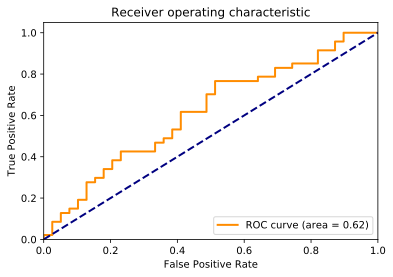

In [79]:
fpr, tpr, _ = roc_curve(y, y_score)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y, y_score))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
